In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
import pandas as pd
import scanpy as sc
import anndata
import os
import sys
import tacco as tc

In [2]:
sys.path.insert(1, '/secure/projects/HTAPP_MBC/src/spatial')
from spatial_utils import *

In [3]:
plots_dir=out_dir_base+"/plots/"
os.makedirs(plots_dir, exist_ok=True)

In [4]:
sample_sheet=pd.read_csv(codeDir+"/meta/sampletracking_HTAPP_MBC_spatial.csv")

In [5]:
#These identifiers are set as defaults in many functions. If names are changed, this has to be adapted when calling the functions.
ct_column='cell_type'
sm_methods=["slide_seq","merfish","merfish_bin","codex","exseq","exseq_bin"] #spatial mathod names are hard-coded for now because some methods need special treatments. Can be fixed by giving eatch method it's own variable.
#sm_methods=["slide_seq","merfish","merfish_bin","codex"]
sc_method="scRNAseq"
all_methods=[sc_method,*sm_methods]
all_methods

['scRNAseq',
 'slide_seq',
 'merfish',
 'merfish_bin',
 'codex',
 'exseq',
 'exseq_bin']

In [6]:
run_samples=list(filter(lambda a: not a in [], list(sample_sheet['sample'].unique()))) 
run_samples

['HTAPP-944-SMP-7479',
 'HTAPP-895-SMP-7359',
 'HTAPP-880-SMP-7179',
 'HTAPP-878-SMP-7149',
 'HTAPP-812-SMP-8239',
 'HTAPP-514-SMP-6760',
 'HTAPP-982-SMP-7629',
 'HTAPP-997-SMP-7789',
 'HTAPP-917-SMP-4531',
 'HTAPP-853-SMP-4381',
 'HTAPP-313-SMP-932',
 'HTAPP-330-SMP-1082',
 'HTAPP-783-SMP-4081',
 'HTAPP-364-SMP-1321',
 'HTAPP-213-SMP-6752']

### Quantitative assessment of colocalisation patterns

In [7]:
def get_cooc_value(adata, analysis_key, interval_id, score_key='log_occ', log_base=None, annotations=None, centers=None):
    interval = adata.uns[analysis_key]['interval']
    selected_interval = (interval[interval_id],interval[interval_id+1])
    #print(f'The selected interval is {selected_interval}')
    values = adata.uns[analysis_key][score_key][:,:,interval_id]
    if annotations is None:
        annotations = adata.uns[analysis_key]['annotation']
    if centers is None:
        centers = adata.uns[analysis_key]['center']
    annotation_ids = [np.argwhere(adata.uns[analysis_key]['annotation'] == anno)[0,0] for anno in annotations]
    center_ids = [np.argwhere(adata.uns[analysis_key]['center'] == center)[0,0] for center in centers]
    values = values[annotation_ids][:,center_ids]
    if log_base is not None:
        values = values / np.log(log_base)
    return pd.DataFrame(values, index=annotations, columns=centers)


In [8]:
def get_cooc_range(adata, analysis_key, decay_factor, score_key='log_occ', annotations=None, centers=None):
    interval = adata.uns[analysis_key]['interval']
    values = adata.uns[analysis_key][score_key]
    if annotations is None:
        annotations = adata.uns[analysis_key]['annotation']
    if centers is None:
        centers = adata.uns[analysis_key]['center']
    annotation_ids = [np.argwhere(adata.uns[analysis_key]['annotation'] == anno)[0,0] for anno in annotations]
    center_ids = [np.argwhere(adata.uns[analysis_key]['center'] == center)[0,0] for center in centers]
    values = values[annotation_ids][:,center_ids]
    arg_max = np.argmax(values, axis=-1)
    val_max = np.max(values, axis=-1)
    arg_min = np.argmin(values, axis=-1)
    val_min = np.min(values, axis=-1)
    direction = values[:,:,0] >= 0
    mirrored = np.where(direction[:,:,None], values, -values)
    arg_max = np.argmax(mirrored, axis=-1)
    val_max = np.max(mirrored, axis=-1)
    lower = mirrored < decay_factor * val_max[:,:,None]
    ranges = np.zeros((values.shape[0], values.shape[1]))
    for i in range(lower.shape[0]):
        for j in range(lower.shape[1]):
            lower_ids = np.argwhere(lower[i,j]).flatten()
            lower_ids = [lower_id for lower_id in lower_ids if lower_id > arg_max[i,j]]
            if len(lower_ids)>0:
                first_lower_after_max = lower_ids[0]
                ranges[i,j] = interval[first_lower_after_max]
            else:
                ranges[i,j] = interval[-1]
            ranges[i,j] *= 2*direction[i,j]-1 # encode direction in sign of range
    return pd.DataFrame(ranges, index=annotations, columns=centers)


In [15]:
value_df=[]
range_df=[]
for typing in ["OT","RCTD"]:
    print(typing)
    for sample in run_samples:
        print(sample)
        out_dir=out_dir_base+sample 
        adatas=get_and_process_data(sample,data_dir,out_dir,methods=all_methods,process=False,verbose=False)
        sel_colors=colors[colors.index.isin(adatas[sc_method].obs[ct_column])]
        for method in adatas.index[~adatas.index.isin(['scRNAseq'])]:
            max_distance = 500
            mal=list(filter(lambda x:'MBC' in x,adatas[method].obs[typing].unique()))
            adatas[method].obs.rename(columns={typing:typing+"_"},inplace=True) # make sure that co_occurrence uses the obsm and not the obs annotation...
            tc.tl.co_occurrence(adatas[method],sample_key='replicate',annotation_key=typing,result_key='co_oc',max_distance=max_distance,
                                numba_blocksize=max_distance,delta_distance=20,counts_location=('obsm','counts'),verbose=0)
        
#            value_df_tmp=get_cooc_value(adatas[method], analysis_key='co_oc', interval_id=0, score_key='log_occ', annotations=['Macrophage',*mal], centers=['Macrophage'])
#            range_df_tmp=get_cooc_range(adatas[method], analysis_key='co_oc', decay_factor=0.25, score_key='log_occ', annotations=['Macrophage',*mal], centers=['Macrophage'])
#do it for all cell types as targets
            value_df_tmp=get_cooc_value(adatas[method], analysis_key='co_oc', interval_id=0, score_key='log_occ', annotations=None, centers=['Macrophage'])
            range_df_tmp=get_cooc_range(adatas[method], analysis_key='co_oc', decay_factor=0.25, score_key='log_occ', annotations=None, centers=['Macrophage'])

            value_df_tmp['method']=method
            value_df_tmp['sample']=sample
            value_df_tmp['typing']=typing
            range_df_tmp['method']=method
            range_df_tmp['sample']=sample
            range_df_tmp['typing']=typing
            value_df.append(value_df_tmp)
            range_df.append(range_df_tmp)
value_df=pd.concat(value_df)
range_df=pd.concat(range_df)
            

OT
HTAPP-944-SMP-7479
HTAPP-895-SMP-7359
HTAPP-880-SMP-7179
HTAPP-878-SMP-7149
HTAPP-812-SMP-8239
HTAPP-514-SMP-6760
HTAPP-982-SMP-7629
HTAPP-997-SMP-7789
HTAPP-917-SMP-4531
HTAPP-853-SMP-4381
HTAPP-313-SMP-932
HTAPP-330-SMP-1082
HTAPP-783-SMP-4081
HTAPP-364-SMP-1321
HTAPP-213-SMP-6752
RCTD
HTAPP-944-SMP-7479
HTAPP-895-SMP-7359
HTAPP-880-SMP-7179
HTAPP-878-SMP-7149
HTAPP-812-SMP-8239
HTAPP-514-SMP-6760
HTAPP-982-SMP-7629
HTAPP-997-SMP-7789
HTAPP-917-SMP-4531
HTAPP-853-SMP-4381
HTAPP-313-SMP-932
HTAPP-330-SMP-1082
HTAPP-783-SMP-4081
HTAPP-364-SMP-1321
HTAPP-213-SMP-6752


In [16]:
value_df.rename(columns={'Macrophage':'Macrophage_strength'},inplace=True)
range_df.rename(columns={'Macrophage':'Macrophage_range'},inplace=True)
value_df.reset_index(names='annot',inplace=True)
range_df.reset_index(names='annot',inplace=True)

In [17]:
value_range_df=value_df.merge(range_df)

In [18]:
value_range_df['Macrophage_range_abs']=np.abs(value_range_df['Macrophage_range'])
value_range_df['annot_unif']=value_range_df['annot'].str.split("_").str[0]

In [19]:
value_range_df.head()

,annot,Macrophage_strength,method,sample,typing,Macrophage_range,Macrophage_range_abs,annot_unif
0,Endothelial_angiogenic,-0.046222,slide_seq,HTAPP-944-SMP-7479,OT,-20.0,20.0,Endothelial
1,Endothelial_vascular,-0.004710,slide_seq,HTAPP-944-SMP-7479,OT,-40.0,40.0,Endothelial
2,Fibroblast,0.005758,slide_seq,HTAPP-944-SMP-7479,OT,480.0,480.0,Fibroblast
3,MBC_neuronal,-0.016346,slide_seq,HTAPP-944-SMP-7479,OT,-20.0,20.0,MBC
4,Macrophage,0.556041,slide_seq,HTAPP-944-SMP-7479,OT,20.0,20.0,Macrophage


In [20]:
value_range_df.to_csv(plots_dir+"cooc_strength_range_all_ct.tsv",sep='\t')

In [9]:
value_range_df=pd.read_csv(plots_dir+"cooc_strength_range_all_ct.tsv",sep='\t')

In [65]:
import plotnine as pl
pl.theme_set(pl.theme_bw(base_size=11))
pl.theme_update(axis_text=pl.element_text(color="black"),panel_grid_major = pl.element_blank(), panel_grid_minor = pl.element_blank(),panel_background = pl.element_rect(fill = "white"))
#matplotlib.rcdefaults()

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 3 in image.
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /scratch/projects/HTAPP_MBC/spatial//01_typing//plots/cooc_strength_range_bp.pdf


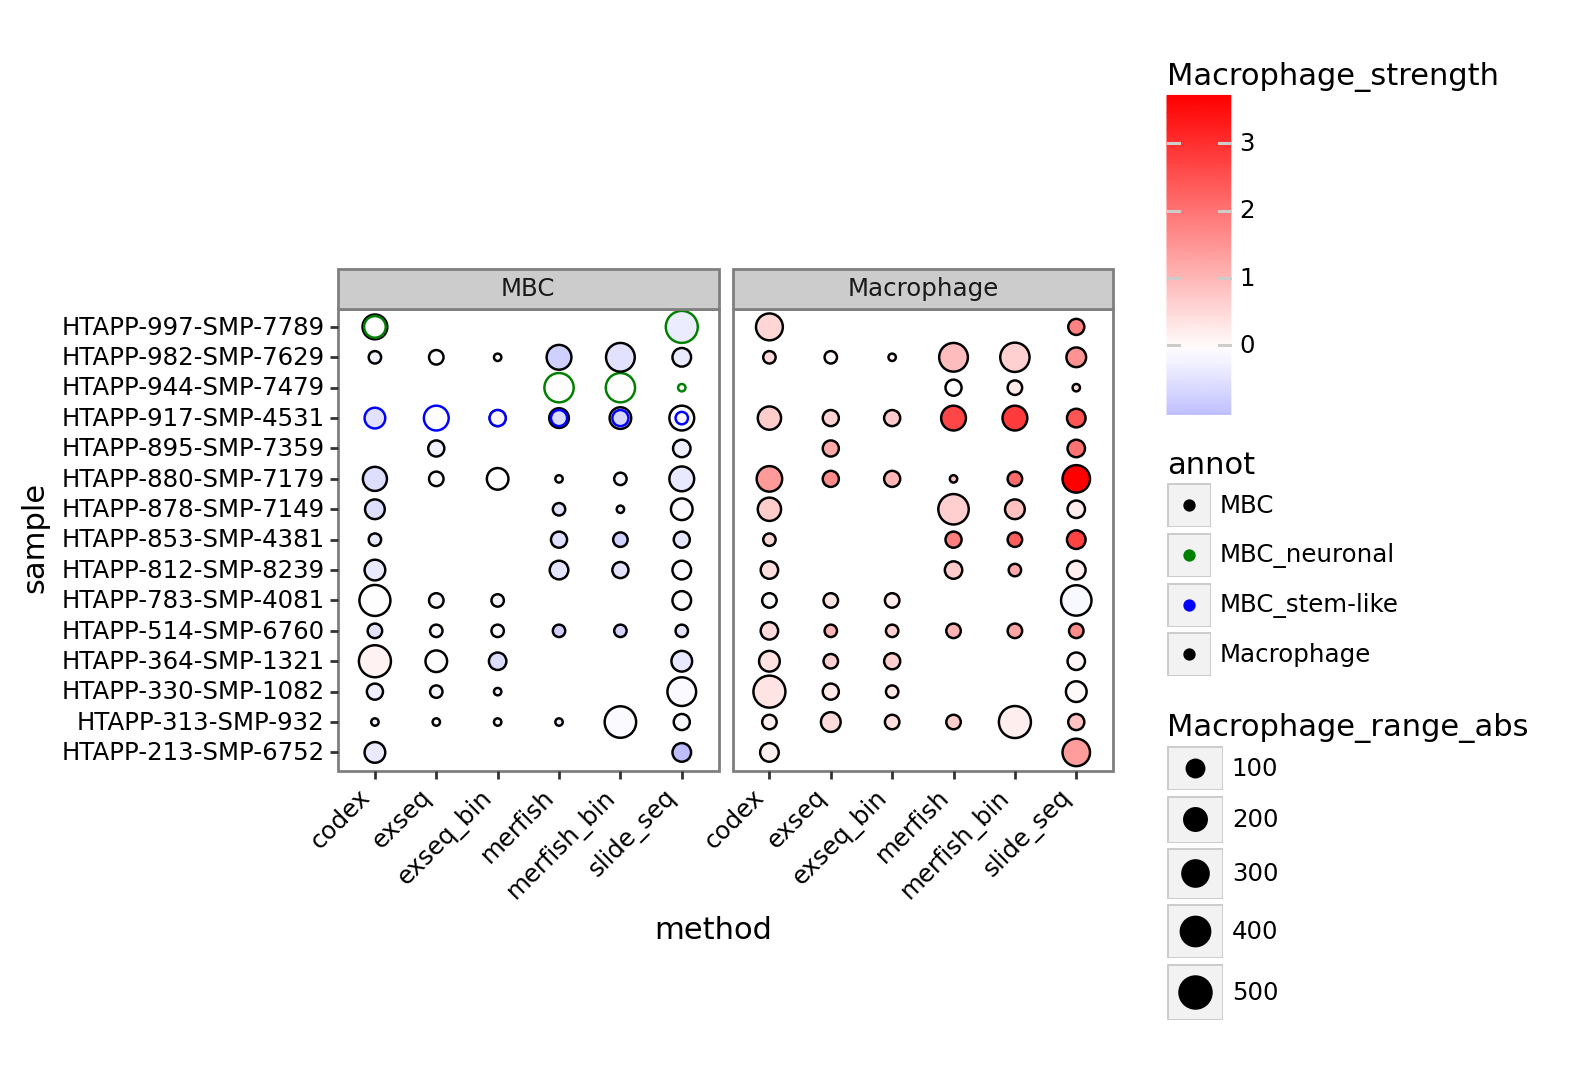

<ggplot: (2969034497109)>

In [31]:
typing='OT'
sel_ct=['Macrophage','MBC_neuronal','MBC_stem-like','MBC']

pl.options.figure_size = (5, 3)
bp=(pl.ggplot(value_range_df[(value_range_df['typing']==typing)&(value_range_df['annot'].isin(sel_ct))],
          pl.aes(x='method',y='sample',size='Macrophage_range_abs',color='annot',fill='Macrophage_strength'))+
 pl.geom_point()+pl.scale_fill_gradient2(low="blue",mid='white',high='red')+pl.facet_wrap('~annot_unif')+
 pl.scale_color_manual(values=['black','green','blue','black'])+pl.theme(axis_text_x=pl.element_text(rotation=45, hjust=1)))
bp.save(plots_dir+"cooc_strength_range_bp.pdf")
bp

In [45]:
value_range_df_agg=value_range_df.groupby(['annot','method','typing'])[['Macrophage_strength','Macrophage_range_abs']].mean().reset_index()
value_range_df_agg['annot']=pd.Categorical(value_range_df_agg['annot'],categories=colors.index, ordered=True)

In [59]:
matplotlib.rcdefaults()

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 4 in image.
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /scratch/projects/HTAPP_MBC/spatial//01_typing//plots/cooc_strength_range_bp_agg_ct.pdf


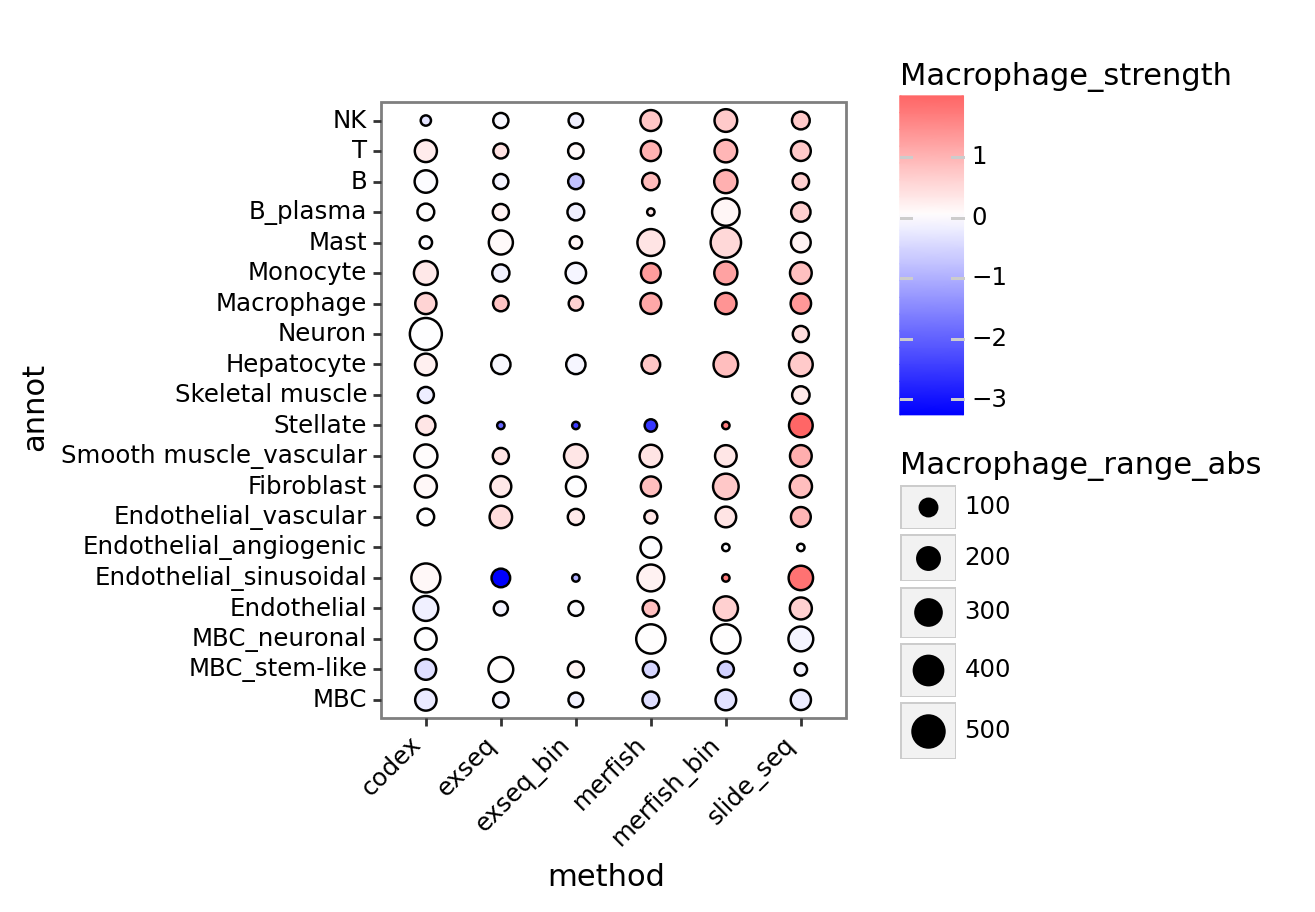

<ggplot: (2969015974075)>

In [66]:
typing='OT'
pl.options.figure_size = (3, 4)
bp=(pl.ggplot(value_range_df_agg[(value_range_df_agg['typing']==typing)],
          pl.aes(x='method',y='annot',size='Macrophage_range_abs',fill='Macrophage_strength'))+
 pl.geom_point()+pl.scale_fill_gradient2(low="blue",mid='white',high='red')+
 pl.theme(axis_text_x=pl.element_text(rotation=45, hjust=1)))
bp.save(plots_dir+"cooc_strength_range_bp_agg_ct.pdf")
bp

In [129]:
value_range_df[(value_range_df['sample']=="HTAPP-917-SMP-4531")&(value_range_df['method']=="merfish")]

,annot,Macrophage_strength,method,sample,typing,Macrophage_range,Macrophage_range_abs,annot_unif
71,Macrophage,2.602939,merfish,HTAPP-917-SMP-4531,OT,260.0,260.0,Macrophage
72,MBC_stem-like,-0.493552,merfish,HTAPP-917-SMP-4531,OT,-80.0,80.0,MBC
73,MBC,-0.304512,merfish,HTAPP-917-SMP-4531,OT,-140.0,140.0,MBC
205,Macrophage,1.111257,merfish,HTAPP-917-SMP-4531,RCTD,220.0,220.0,Macrophage
206,MBC_stem-like,-0.149789,merfish,HTAPP-917-SMP-4531,RCTD,-160.0,160.0,MBC
207,MBC,-0.178007,merfish,HTAPP-917-SMP-4531,RCTD,-220.0,220.0,MBC


In [130]:
cts=['Macrophage','MBC']
vals=['Macrophage_range','Macrophage_strength']

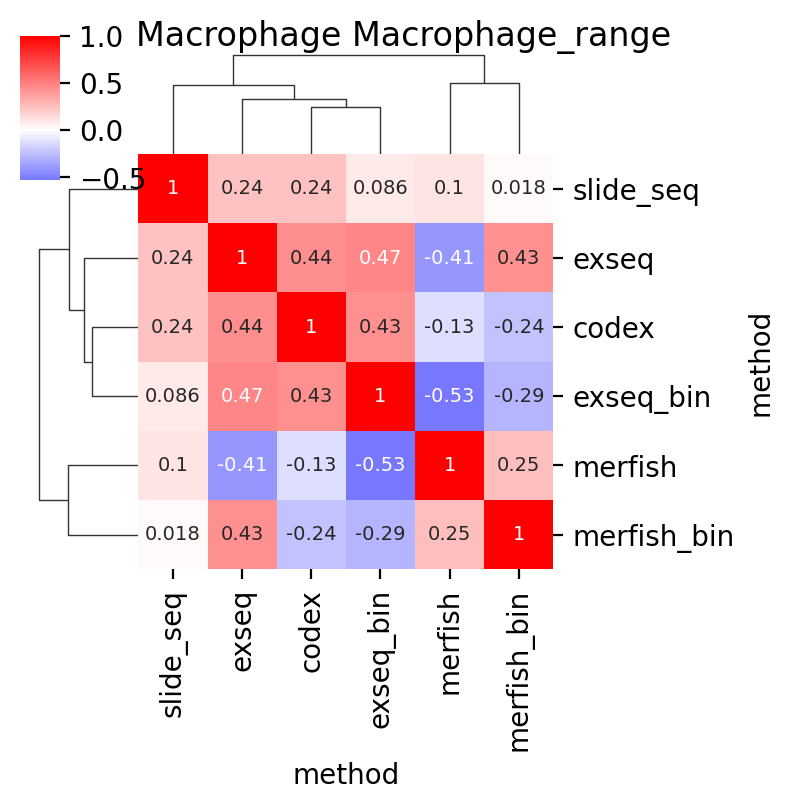

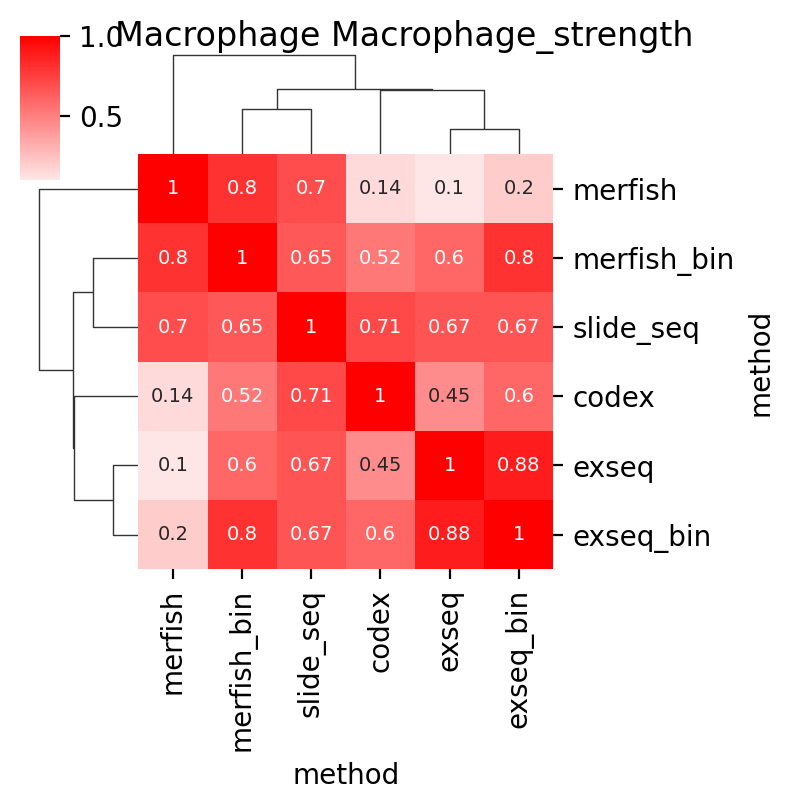

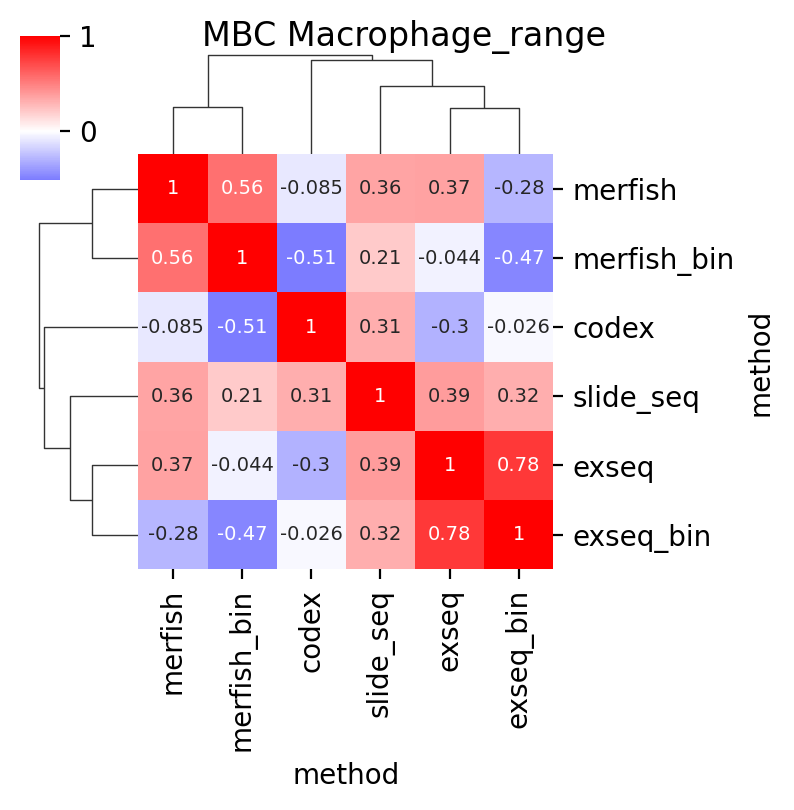

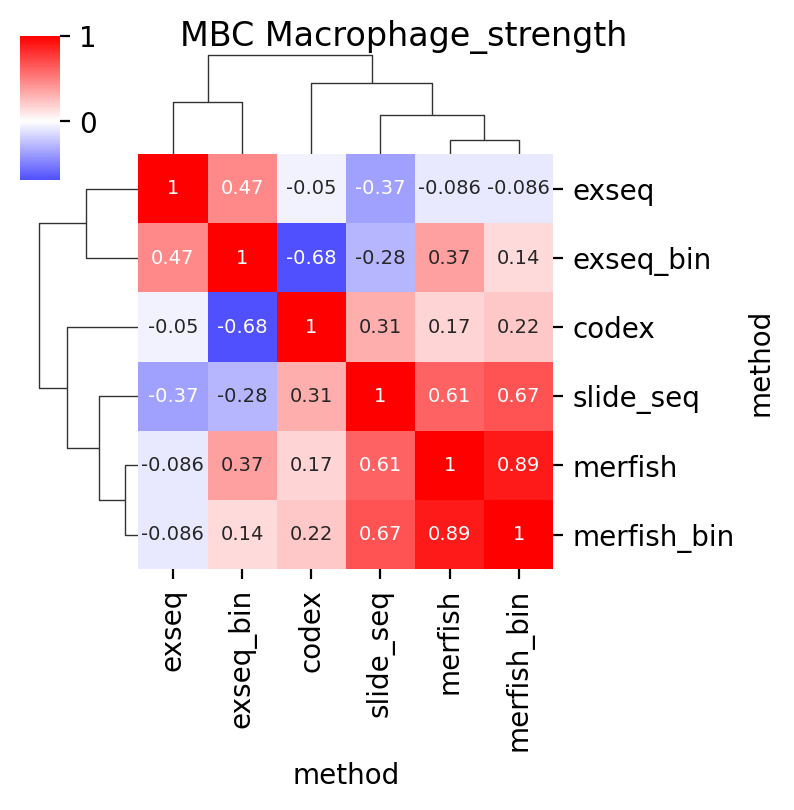

In [137]:
hms=[]
for ct in cts:
    for val in vals:
        df_wide=value_range_df[(value_range_df['annot_unif']==ct)&(value_range_df['typing']=='OT')].pivot(index=['sample','annot'], columns='method', values=val)
        cors=df_wide.corr(method="spearman")
        hm=sns.clustermap(cors,cmap="bwr",center=0,dendrogram_ratio=0.2,figsize=[4,4],annot=True,annot_kws={"size": 7},)
        hm.fig.suptitle(ct+ ' ' +val,y=1) 
        hms.append(hm)
        hm.savefig(plots_dir+"cooc_cor_hm"+'_'+ct+'_'+val+".pdf")

In [58]:
cors=value_df_wide.corr(method="spearman")

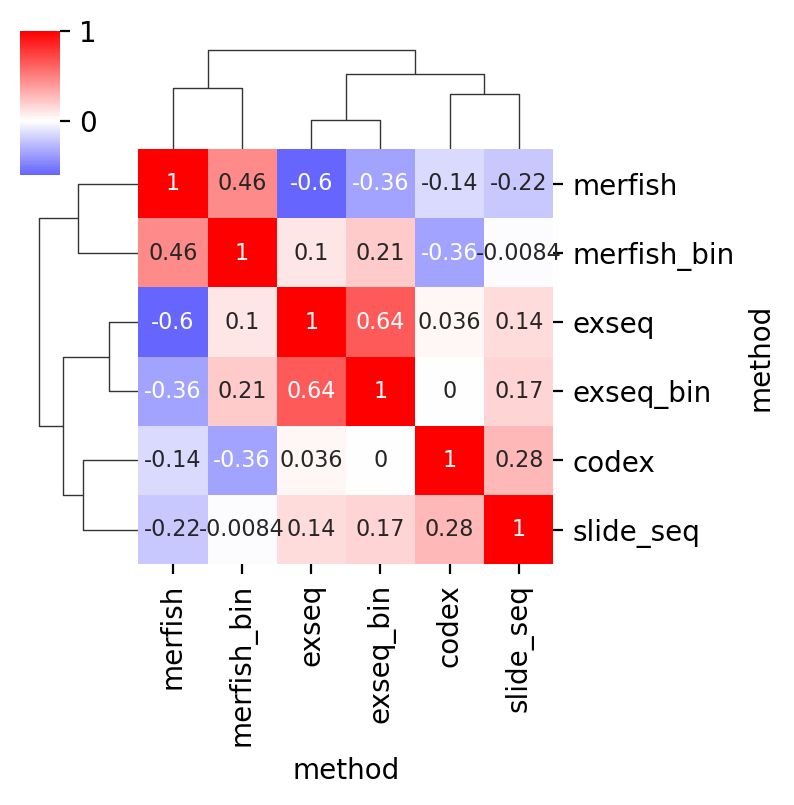

In [60]:
hm=sns.clustermap(cors,cmap="bwr",center=0,dendrogram_ratio=0.2,figsize=[4,4],annot=True,annot_kws={"size": 8})
#hm.savefig(plots_dir+"mp_mp_cooc_strength_cor_hm.pdf")